In [1]:
from scipy.io import loadmat
import h5py
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline

In [2]:
filelist = ["calcium_data/140708B_140811a_result", 
            "calcium_data/140909C_141112a_result", 
            "calcium_data/141006C_141121a_result",
            "calcium_data/150109A_150302a_result", 
            "calcium_data/151122A_160202a_result", 
            "calcium_data/151122B_160207a_result", 
            "calcium_data/160209A_160430a_result", 
            "calcium_data/160209B_160428a_result"]

In [3]:
filename = filelist[0]
f = h5py.File(filename+".hdf5", "r")

In [206]:
#average delta F
#1s = 59 frames
data = f['data']
meta = f['meta']

amp = 2
site = 0

mn_dnd_chng = np.mean(data[:,:,:60], axis=2)

present_mask = meta[:,1]==amp
absent_mask = meta[:,1]==0

In [207]:
present = mn_dnd_chng[present_mask,site]
absent = mn_dnd_chng[absent_mask,site]

min_crit = np.min(absent)
max_crit = np.max(present)

tp = []
fp = []

for crit in np.linspace(min_crit, max_crit, 1000):
    tp.append(np.sum(present>crit)/present.shape[0])
    fp.append(np.sum(absent>crit)/absent.shape[0])

(0, 1)

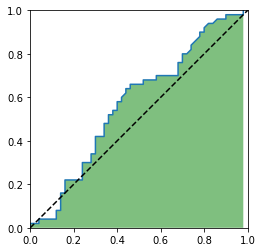

In [208]:
fig, ax = plt.subplots()
ax.plot(fp, tp)
ax.plot(np.linspace(0,1,1000), np.linspace(0,1,1000), color='k', linestyle='--')
ax.fill_between(fp, np.zeros(1000), tp, facecolor='green', alpha=0.5)
ax.set_aspect('equal')
ax.set_xlim((0,1))
ax.set_ylim((0,1))

In [212]:
np.sum(np.asarray(fp))/1000

0.19748000000000002

In [204]:
np.sum(fp)

61.039999999999999